
=== Corpus: brown ===
Tokens (alpha): 981716
Pairs counted: 6581 ; total links: 785884


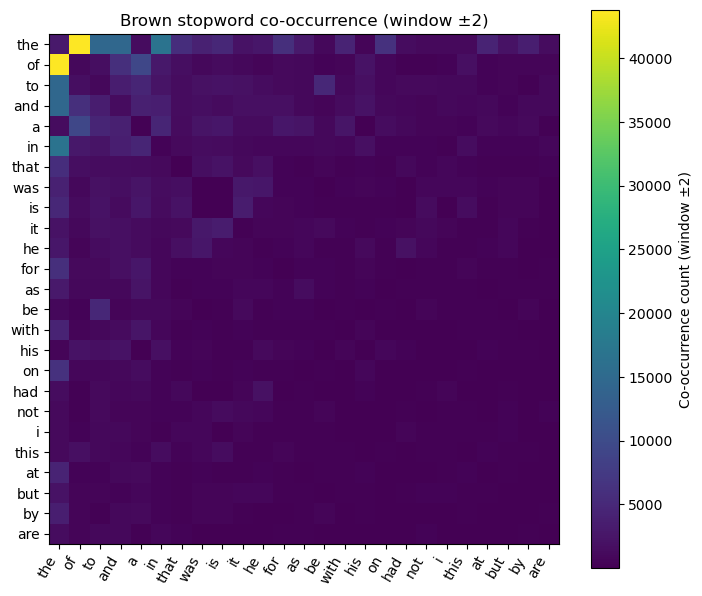

Saved (relative):
- artifacts/spec8_brown_stopword_pairs.csv
- artifacts/spec8_brown_heatmap.png

=== Corpus: gutenberg ===
Tokens (alpha): 2135400
Pairs counted: 8273 ; total links: 2077594


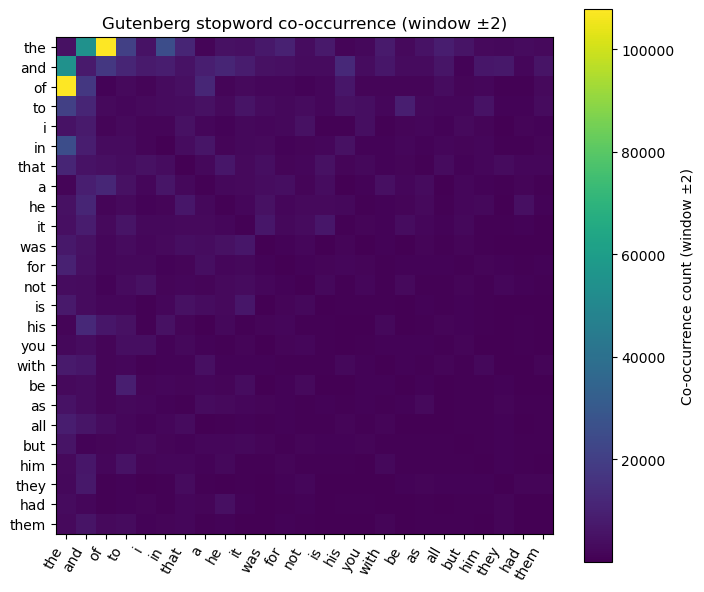

Saved (relative):
- artifacts/spec8_gutenberg_stopword_pairs.csv
- artifacts/spec8_gutenberg_heatmap.png

=== Corpus: webtext ===
Tokens (alpha): 306055
Pairs counted: 5572 ; total links: 218632


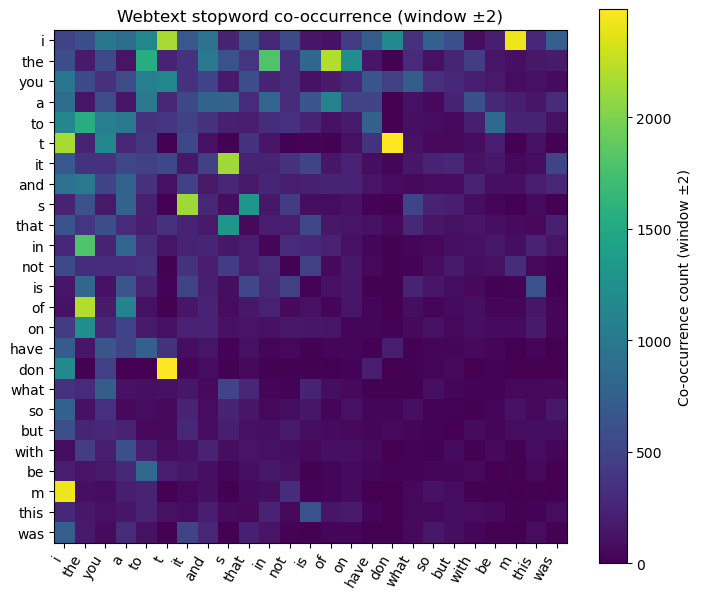

Saved (relative):
- artifacts/spec8_webtext_stopword_pairs.csv
- artifacts/spec8_webtext_heatmap.png

=== Corpus: nps_chat ===
Tokens (alpha): 34297
Pairs counted: 2291 ; total links: 20182


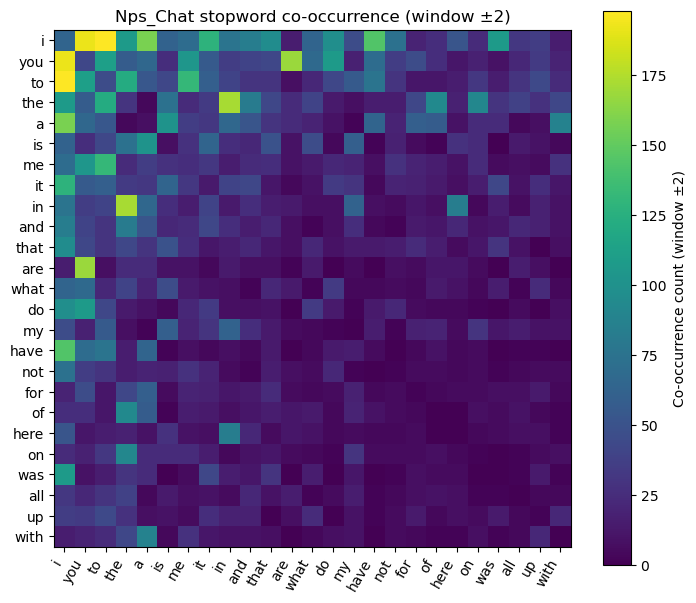

Saved (relative):
- artifacts/spec8_nps_chat_stopword_pairs.csv
- artifacts/spec8_nps_chat_heatmap.png

=== Corpus: reuters ===
Tokens (alpha): 1327141
Pairs counted: 5272 ; total links: 573754


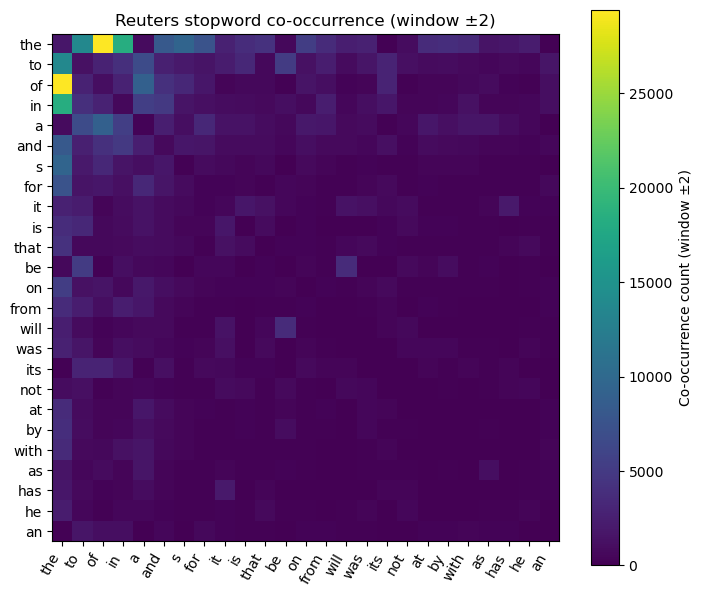

Saved (relative):
- artifacts/spec8_reuters_stopword_pairs.csv
- artifacts/spec8_reuters_heatmap.png

=== Summary (saved) ===


,corpus,tokens_alpha,unique_stopwords_seen,pairs_nonzero,total_links,sum_degrees,top_pair_pmi,top_pair_pmi_val,top_pair_co_count
0,brown,981716,137,6581,785884,1571768,o-o,6.099,4
1,gutenberg,2135400,152,8273,2077594,4155188,y-yours,5.142,2
2,webtext,306055,150,5572,218632,437264,yourself-yourselves,5.846,2
3,nps_chat,34297,127,2291,20182,40364,by-himself,4.947,6
4,reuters,1327141,146,5272,573754,1147508,why-yourself,5.825,2


artifacts/spec8_summary_across_corpora.csv


In [1]:
# Spec 8 — Stopword connection strength via windowed co-occurrence (±2 tokens)
# Corpora: Brown, Gutenberg, WebText, NPS Chat, Reuters
# For each corpus:
#   - Count co-occurrences for stopword pairs within distance<=2
#   - Build pair table with co_count, degree(i), degree(j), PMI
#   - Save CSV + Heatmap (Top-25 nodes by degree)
# Comments in simple English; all outputs under artifacts/

import os, math, nltk, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter, defaultdict
from IPython.display import display

# ---------- paths ----------
ART_DIR = os.path.abspath("../artifacts" if os.path.basename(os.getcwd())=="notebooks" else "./artifacts")
os.makedirs(ART_DIR, exist_ok=True)

# ---------- downloads ----------
for pkg in ["punkt","stopwords","brown","gutenberg","webtext","nps_chat","reuters"]:
    nltk.download(pkg, quiet=True)

from nltk.corpus import stopwords, brown, gutenberg, webtext, nps_chat, reuters

# ---------- helpers ----------
def alpha_lower(tokens):
    """Lowercase + keep alphabetic tokens only."""
    for t in tokens:
        t = t.lower()
        if t.isalpha():
            yield t

def corpus_tokens(name):
    """Return a flat list of tokens for the given corpus name."""
    if name == "brown":
        toks = brown.words()
    elif name == "gutenberg":
        toks = []
        for fid in gutenberg.fileids():
            toks.extend(gutenberg.words(fid))
    elif name == "webtext":
        toks = []
        for fid in webtext.fileids():
            toks.extend(webtext.words(fid))
    elif name == "nps_chat":
        toks = []
        for fid in nps_chat.fileids():
            toks.extend(nps_chat.words(fid))
    elif name == "reuters":
        toks = []
        for fid in reuters.fileids():
            toks.extend(reuters.words(fid))
    else:
        toks = []
    return list(alpha_lower(toks))

def cooccurrence_within_window(tokens, stop_set, window_radius=2):
    """
    Count co-occurrences between stopwords within +/- window_radius.
    We count unordered pairs (i<j) per occurrence, symmetric.
    Returns:
      co_counts: dict[(w1,w2)] -> int
      deg: dict[word] -> total links count (degree)
      freq: Counter of stopwords
    """
    n = len(tokens)
    freq = Counter()
    co_counts = Counter()
    deg = Counter()

    for idx, w in enumerate(tokens):
        if w not in stop_set: 
            continue
        freq[w] += 1
        start = max(0, idx - window_radius)
        end   = min(n, idx + window_radius + 1)
        # neighbors in window (exclude center idx)
        for j in range(start, end):
            if j == idx: 
                continue
            v = tokens[j]
            if v in stop_set:
                a, b = (w, v) if w <= v else (v, w)  # unordered key
                co_counts[(a, b)] += 1
                deg[w] += 1
                deg[v] += 1
    return co_counts, deg, freq

def pmi_from_counts(co_counts, deg):
    """
    Compute PMI using link-probabilities:
      p(i,j) = co_ij / sum_all_co
      p(i)   = deg(i) / sum_all_co
      PMI = log( p(i,j) / (p(i)*p(j)) )
    """
    total_links = float(sum(co_counts.values()))
    if total_links <= 0:
        return {k: float("-inf") for k in co_counts}
    pmi = {}
    # precompute p(i)
    p_node = {w: deg[w]/total_links for w in deg}
    for (w1, w2), cij in co_counts.items():
        pij = cij / total_links
        denom = (p_node.get(w1, 1e-12) * p_node.get(w2, 1e-12))
        val = math.log((pij + 1e-12) / (denom + 1e-12))
        pmi[(w1, w2)] = val
    return pmi

def build_pair_df(co_counts, deg, freq, pmi):
    """Create DataFrame with pair metrics."""
    rows = []
    for (w1, w2), c in co_counts.items():
        rows.append({
            "w1": w1, "w2": w2,
            "co_count": int(c),
            "deg_w1": int(deg[w1]), "deg_w2": int(deg[w2]),
            "freq_w1": int(freq[w1]), "freq_w2": int(freq[w2]),
            "pmi": pmi.get((w1, w2), float("-inf"))
        })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["pmi","co_count"], ascending=[False, False]).reset_index(drop=True)
    return df

def plot_heatmap_top_nodes(co_counts, top_nodes, outpath, title):
    """Heatmap of co_count for top_nodes (symmetric matrix)."""
    nodes = list(top_nodes)
    idx = {w:i for i,w in enumerate(nodes)}
    M = np.zeros((len(nodes), len(nodes)), dtype=float)
    for (a,b), c in co_counts.items():
        if a in idx and b in idx:
            i, j = idx[a], idx[b]
            M[i,j] = c
            M[j,i] = c
    plt.figure(figsize=(7.2,6.2))
    plt.imshow(M, interpolation='nearest')
    plt.xticks(range(len(nodes)), nodes, rotation=60, ha="right")
    plt.yticks(range(len(nodes)), nodes)
    plt.title(title)
    plt.colorbar(label="Co-occurrence count (window ±2)")
    plt.tight_layout()
    plt.savefig(outpath, dpi=160)
    plt.show()

# ---------- config ----------
CORPORA = ["brown","gutenberg","webtext","nps_chat","reuters"]
L = set(stopwords.words("english"))
WINDOW = 2
TOPN_HEAT = 25  # number of nodes (stopwords) to visualize in heatmap

# ---------- main loop ----------
summary_rows = []

for cname in CORPORA:
    print(f"\n=== Corpus: {cname} ===")
    tokens = corpus_tokens(cname)
    print(f"Tokens (alpha): {len(tokens)}")

    co_counts, deg, freq = cooccurrence_within_window(tokens, L, window_radius=WINDOW)
    print(f"Pairs counted: {len(co_counts)} ; total links: {sum(co_counts.values())}")

    pmi = pmi_from_counts(co_counts, deg)
    df_pairs = build_pair_df(co_counts, deg, freq, pmi)

    # Save full pair table
    csv_pairs = os.path.join(ART_DIR, f"spec8_{cname}_stopword_pairs.csv")
    df_pairs.to_csv(csv_pairs, index=False)

    # Choose top nodes by degree for heatmap
    top_nodes = [w for w,_ in sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:TOPN_HEAT]]
    heat_png = os.path.join(ART_DIR, f"spec8_{cname}_heatmap.png")
    if top_nodes:
        plot_heatmap_top_nodes(co_counts, top_nodes, heat_png,
                               title=f"{cname.title()} stopword co-occurrence (window ±2)")

    # Collect quick stats
    if not df_pairs.empty:
        top5_pmi = df_pairs.head(5)[["w1","w2","pmi","co_count"]]
        # sum of degrees across nodes (useful density proxy)
        total_deg = int(sum(deg.values()))
        summary_rows.append({
            "corpus": cname,
            "tokens_alpha": len(tokens),
            "unique_stopwords_seen": int(sum(1 for w in L if freq[w] > 0)),
            "pairs_nonzero": int(len(co_counts)),
            "total_links": int(sum(co_counts.values())),
            "sum_degrees": total_deg,
            "top_pair_pmi": f"{top5_pmi.iloc[0]['w1']}-{top5_pmi.iloc[0]['w2']}",
            "top_pair_pmi_val": round(float(top5_pmi.iloc[0]['pmi']), 3),
            "top_pair_co_count": int(top5_pmi.iloc[0]['co_count'])
        })
    else:
        summary_rows.append({
            "corpus": cname, "tokens_alpha": len(tokens),
            "unique_stopwords_seen": 0,
            "pairs_nonzero": 0, "total_links": 0, "sum_degrees": 0,
            "top_pair_pmi": "", "top_pair_pmi_val": float("nan"), "top_pair_co_count": 0
        })

    # Print saved paths (relative)
    print("Saved (relative):")
    print(f"- artifacts/{os.path.basename(csv_pairs)}")
    print(f"- artifacts/{os.path.basename(heat_png)}")

# ---------- summary over corpora ----------
df_sum = pd.DataFrame(summary_rows)
sum_csv = os.path.join(ART_DIR, "spec8_summary_across_corpora.csv")
df_sum.to_csv(sum_csv, index=False)
print("\n=== Summary (saved) ===")
display(df_sum)
print(f"artifacts/{os.path.basename(sum_csv)}")
